# Aggregation Machine Learning 

## Loading packages 

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import numpy as np
np.set_printoptions(threshold=sys.maxsize)
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles
import statistics
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import RobustScaler
from scipy import stats
from scipy.stats import mannwhitneyu, fisher_exact
from scipy.stats import kurtosis
from scipy.stats import skew
from scipy.stats import norm
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import random 
from statsmodels.stats.multitest import fdrcorrection


## Loading data and using the 279 most soluble ones

In [49]:
df = pd.read_csv('Final_merged_dataset.csv')
df = df.drop(["Unnamed: 0", "Gene","Gene_name","Uniprot_ID","set","Tissue","fasta_sequence"], axis =1)
new =df['solubility'].nlargest(n=279)
sol = df.loc[df['solubility'].isin(new)]
aggregator = df.loc[df['Binary_set'] == 0]
new_df = aggregator.append(sol).reset_index(drop=True)
new_df = new_df.sample(frac=1).reset_index(drop=True)

seq_features = ['Binary_set','length', 'hydr_count', 'polar_count', 'molecular_weight', 'helix', 'turn', 'sheet', 'A', 'C', 'D', 'E', 'F', 
                'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y', 'thsa_netsurfp2', 'tasa_netsurfp2', 
                'rhsa_netsurfp2', 'disorder', 'A_exposed', 'C_exposed', 'D_exposed', 'E_exposed', 'F_exposed',
                'G_exposed', 'H_exposed', 'I_exposed', 'K_exposed', 'L_exposed', 'M_exposed', 'N_exposed', 'P_exposed', 
                'Q_exposed', 'R_exposed', 'S_exposed', 'T_exposed', 'V_exposed', 'W_exposed', 'Y_exposed', 
                 'Aromaticity', 'Instability_index', 'Gravy', 
                'isoelectric_point_x', 'charge_at_7', 'charge_at_5', 'PTM_MSD', 'Phosphorylation_MSD',
                'Glycosylation_MSD', 'Ubiquitination_MSD', 'SUMOylation_MSD', 'Acetylation_MSD', 'Palmitoylation_MSD', 
                'Methylation_MSD', 'Polar_exposed', 'Hydrophobic_exposed','LHPpred','max_NX']
plot_df =  new_df
new_df = new_df[seq_features]
new_df.dropna(axis=0, how='any', thresh=None, subset=None, inplace=True)
col_names = new_df.columns.tolist()

new_df


/Users/priya/opt/anaconda3/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


,Binary_set,length,hydr_count,polar_count,molecular_weight,helix,turn,sheet,A,C,...,Glycosylation_MSD,Ubiquitination_MSD,SUMOylation_MSD,Acetylation_MSD,Palmitoylation_MSD,Methylation_MSD,Polar_exposed,Hydrophobic_exposed,LHPpred,max_NX
0,0,8.426265,0.424419,0.366279,15.450254,0.156977,0.595930,0.247093,0.078488,0.055233,...,1.0,0.0,0.0,0.0,0.0,1.0,0.576389,0.152778,1485.479065,52.9
1,1,7.971544,0.501992,0.274900,14.980946,0.661355,0.338645,0.000000,0.067729,0.007968,...,1.0,0.0,0.0,1.0,0.0,1.0,0.400000,0.351724,6204.303244,17.8
2,1,7.918863,0.413223,0.388430,14.941519,0.338843,0.500000,0.161157,0.057851,0.045455,...,0.0,0.0,0.0,0.0,1.0,1.0,0.610000,0.130000,1247.199980,23.9
3,1,10.319672,0.496870,0.311424,17.333569,0.513302,0.398279,0.088419,0.068858,0.038341,...,1.0,0.0,0.0,0.0,1.0,0.0,0.574026,0.202597,5373.887662,27.7
4,0,8.629357,0.378788,0.449495,15.682520,0.320707,0.535354,0.143939,0.055556,0.015152,...,1.0,0.0,1.0,0.0,0.0,1.0,0.670520,0.144509,882.618646,39.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
553,1,8.321928,0.462500,0.334375,15.332349,0.740625,0.253125,0.006250,0.090625,0.021875,...,1.0,0.0,0.0,0.0,0.0,0.0,0.526786,0.276786,5857.315837,14.7
554,0,9.525521,0.336499,0.446404,16.548045,0.320217,0.559023,0.120760,0.058345,0.013569,...,1.0,0.0,0.0,0.0,0.0,1.0,0.621027,0.114914,882.618646,33.0
555,0,8.867279,0.381156,0.441113,15.899307,0.381156,0.541756,0.077088,0.057816,0.012848,...,1.0,0.0,0.0,0.0,0.0,1.0,0.641026,0.162393,1099.636679,22.9
556,1,8.839204,0.454148,0.351528,15.838848,0.451965,0.358079,0.189956,0.082969,0.034934,...,1.0,0.0,0.0,0.0,0.0,0.0,0.671642,0.074627,1247.199980,32.3


[Text(0, 0, 'Aggregator'), Text(1, 0, 'Soluble')]

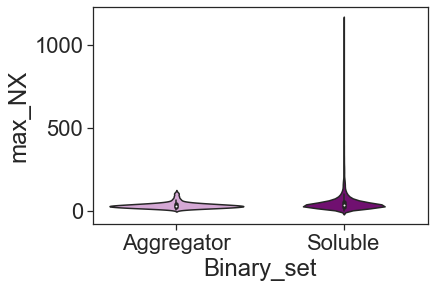

In [50]:
my_pal = {0: "plum", 1: "purple"}
ax = sns.violinplot(x='Binary_set', y='max_NX', palette=my_pal, data=df)
ax.set_xticklabels(["Aggregator",'Soluble'])

## Analysing data

### LHP pred vs Aggregator

p = 0.000000
skewness = 2.734392
kurtosis = 6.560255


[Text(0, 0, 'Aggregator'), Text(1, 0, 'Soluble')]

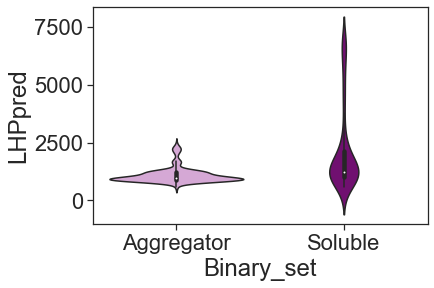

In [51]:
k2, p = stats.normaltest(new_df["LHPpred"], nan_policy = "omit")
print("p = {:f}".format(p))
print("skewness = {:f}".format(skew(new_df["LHPpred"], nan_policy = "omit")))
print("kurtosis = {:f}".format(kurtosis(new_df["LHPpred"], nan_policy = "omit")))
my_pal = {0: "plum", 1: "purple"}
ax = sns.violinplot(x='Binary_set', y="LHPpred", data=new_df, palette=my_pal, showmeans=True, )
ax.set_xticklabels(["Aggregator",'Soluble'])

Text(0.5, 0, 'LHP prediction')

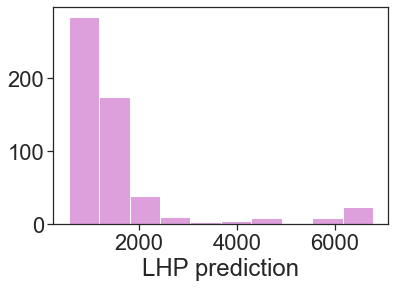

In [52]:
plt.hist(new_df["LHPpred"], color = "plum")
plt.xlabel("LHP prediction")

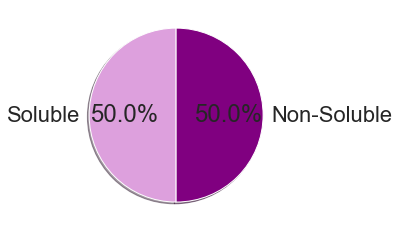

In [53]:
part = np.array((new_df["Binary_set"].sum()/(len(new_df["Binary_set"])), 1- (new_df["Binary_set"].sum()/(len(new_df["Binary_set"])))))
labels = ["Soluble", "Non-Soluble"]
colors = ["plum", "purple"]
plt.pie(part, labels= labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=90)
plt.show()

###  Expression vs Aggregator

p = 0.000000
skewness = 4.589033
kurtosis = 30.007519


[Text(0, 0, 'Aggregator'), Text(1, 0, 'Soluble')]

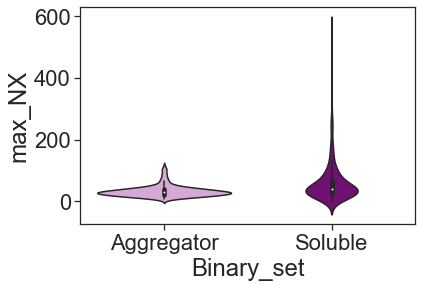

In [54]:
k2, p = stats.normaltest(new_df['max_NX'], nan_policy = "omit")
print("p = {:f}".format(p))
print("skewness = {:f}".format(skew(new_df['max_NX'], nan_policy = "omit")))
print("kurtosis = {:f}".format(kurtosis(new_df['max_NX'], nan_policy = "omit")))
my_pal = {0: "plum", 1: "purple"}
ax = sns.violinplot(x='Binary_set', y='max_NX', palette=my_pal, data=new_df)
ax.set_xticklabels(["Aggregator",'Soluble'])

Text(0.5, 0, 'Expression')

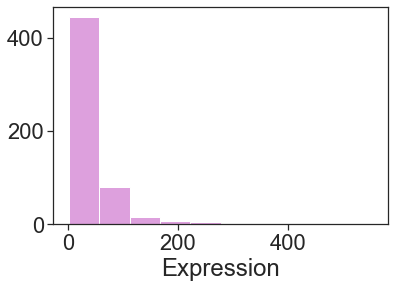

In [55]:
plt.hist(new_df['max_NX'], color = "plum")
plt.xlabel("Expression")

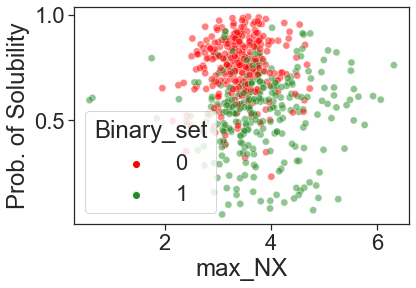

In [56]:
marker_size=2
my_pal = {0: "red", 1: "forestgreen"}
sns.scatterplot(x=np.log(plot_df['max_NX']+1), 
                y=plot_df['Prob. of Solubility'],
                s=50,
                hue=plot_df['Binary_set'],
                data=plot_df,palette = my_pal, alpha=0.5)


# plt.scatter(np.log(df['max_NX']+1),df['Prob. of Solubility'] , marker_size, hue =df['Binary_set'] , c=df['Binary_set'].astype('category').cat.codes)
# plt.xlabel("Expression")
# plt.ylabel("Aggregation propensity")
plt.savefig('Figures/2Dplot.png',dpi=300, bbox_inches='tight')
plt.show()

## Machine Learning 

In [62]:
def get_normalised_df(df):
    df_min_max_scaled = df.copy()
    # apply normalization to all columns
    for column in df_min_max_scaled:
        if column != 'Binary_set':
            df_min_max_scaled[column] = (df_min_max_scaled[column] - df_min_max_scaled[column].min()) / (df_min_max_scaled[column].max() - df_min_max_scaled[column].min())    
    return df_min_max_scaled

In [63]:
Final_DNASU_ML = get_normalised_df(new_df)
df_train, df_test_val = train_test_split(Final_DNASU_ML, test_size=0.2)
df_test, df_val = train_test_split(df_test_val, test_size=0.5)
df_train =df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
print(len(df_train), len(df_test), len(df_val))

446 56 56


In [64]:
x_train, x_test, y_train, y_test = train_test_split(Final_DNASU_ML.drop('Binary_set', axis = 1), Final_DNASU_ML['Binary_set'],test_size=0.2,random_state=0,stratify=Final_DNASU_ML['Binary_set'])
x_test, x_validate, y_test, y_validate = train_test_split(x_test, y_test,test_size=0.5,random_state=0,stratify=y_test)
df_train = pd.concat([y_train,x_train], axis =1).reset_index(drop=True)
df_test = pd.concat([y_test,x_test], axis =1).reset_index(drop=True)
df_val = pd.concat([y_validate,x_validate], axis =1).reset_index(drop=True)

In [66]:
sum(df_train["Binary_set"])

223

In [13]:
#Labels are the values to be predicted, in this case the solubility
Train_labels = np.array(df_train['Binary_set'])

# Remove the labels from the features
Train_features= df_train.drop('Binary_set', axis = 1)

# Saving feature names for later use
Train_feature_list = list(Train_features.columns)

# Convert to numpy array
Train_features = np.array(Train_features)
# Train_features = RobustScaler().fit_transform(Train_features)


#Same thing for test set
Test_labels = np.array(df_test['Binary_set'])
Test_features = df_test.drop('Binary_set', axis = 1)
Test_feature_list = list(Test_features.columns)
Test_features = np.array(Test_features)
# Test_features = RobustScaler().fit_transform(Test_features)

#And the cleaned test set
Test_labels2 = np.array(df_val['Binary_set'])
Test_features2 = df_val.drop('Binary_set', axis = 1)
Test_feature_list2 = list(Test_features2.columns)
Test_features2 = np.array(Test_features2)
# Test_features2 = RobustScaler().fit_transform(Test_features2)

#Check shape of train and test
print('Training Features Shape:', Train_features.shape)
print('Training Labels Shape:', Train_labels.shape)
print('Testing Features Shape:', Test_features.shape)
print('Testing Labels Shape:', Test_labels.shape)
print('Cleaned testing Features Shape:', Test_features2.shape)
print('Cleaned testing Labels Shape:', Test_labels2.shape)


Training Features Shape: (446, 69)
Training Labels Shape: (446,)
Testing Features Shape: (56, 69)
Testing Labels Shape: (56,)
Cleaned testing Features Shape: (56, 69)
Cleaned testing Labels Shape: (56,)


In [14]:
#Support vector
svc = SVC(random_state=42, probability=True)
svc.fit(Train_features, Train_labels)

#random forest
rf = RandomForestClassifier(n_estimators = 100, bootstrap = True, max_features = 'sqrt')
rf.fit(Train_features, Train_labels)

#Logistic regression
lr = LogisticRegression(max_iter = 10000)
lr.fit(Train_features, Train_labels)

LogisticRegression(max_iter=10000)

In [15]:
# Use the forest's predict method on the test data
rf_predictions = rf.predict(Test_features)

# Probabilities for each class
rf_probs = rf.predict_proba(Test_features)[:, 1]

#same for cleaned test set
rf_predictions2 = rf.predict(Test_features2)
rf_probs2 = rf.predict_proba(Test_features2)[:, 1]

In [16]:
# Calculate roc auc 
roc_value = roc_auc_score(Test_labels, rf_probs)
print('AUC:', roc_value)

#same for cleaned
roc_value = roc_auc_score(Test_labels2, rf_probs2)
print('AUC:', roc_value)

AUC: 0.8801020408163265
AUC: 0.8775510204081632


In [17]:
def get_AUC(model, x_train, x_test, y_train, y_test):
    rf = model.fit(x_train, y_train)
    rf_predictions = rf.predict(x_test)
    rf_probs = rf.predict_proba(x_test)[:, 1]
    roc_value = roc_auc_score(y_test, rf_probs)
    return roc_value

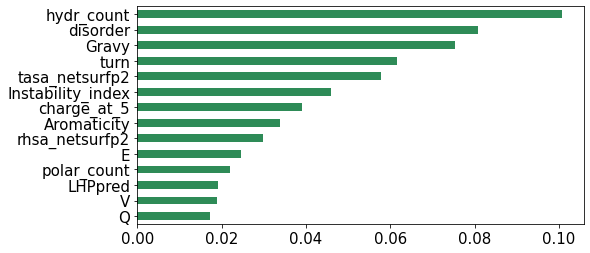

In [18]:
# Extract feature importances
fi = pd.DataFrame({'feature': (Train_feature_list),
                   'importance': rf.feature_importances_}).\
                    sort_values('importance', ascending = False)

# Display
fi
fi[:10]
# fi.plot.bar(x = "feature", y ='importance' )
# train_X_seq = df_train.drop('Binary_set', axis = 1)

feature_importance = pd.Series(index = df_train.drop('Binary_set', axis = 1).columns.values, data = rf.feature_importances_)
feature_importance.sort_values(ascending = True)[55:].plot(kind='barh',  figsize=(8,4), color="seagreen", fontsize=15)
fig = plt.gcf()
plt.savefig('Figures/featureImportance.png', dpi=300, bbox_inches='tight')


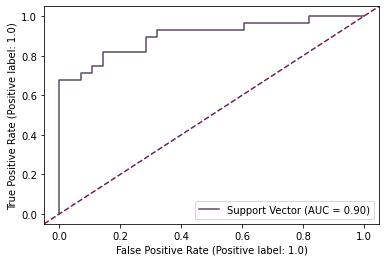

In [19]:
sns.set_palette("rocket")
ax = plt.gca()
svc_disp2 = plot_roc_curve(svc, Test_features2, Test_labels2,name='Support Vector', ax=ax, alpha=0.8)
ax.plot([0, 1], [0, 1],linestyle='--', transform=ax.transAxes)
plt.show()

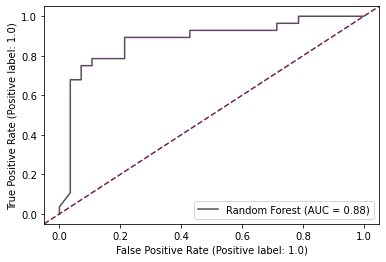

In [20]:
ax = plt.gca()
rf_disp2 = plot_roc_curve(rf, Test_features2, Test_labels2,name='Random Forest', ax=ax, alpha=0.8)
ax.plot([0, 1], [0, 1],linestyle='--', transform=ax.transAxes)
plt.show()

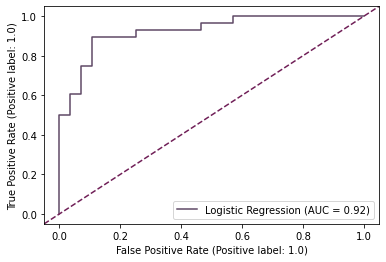

In [21]:
ax = plt.gca()
svc_disp2 = plot_roc_curve(lr, Test_features2, Test_labels2,name='Logistic Regression', ax=ax, alpha=0.8)
ax.plot([0, 1], [0, 1],linestyle='--', transform=ax.transAxes)
plt.show()

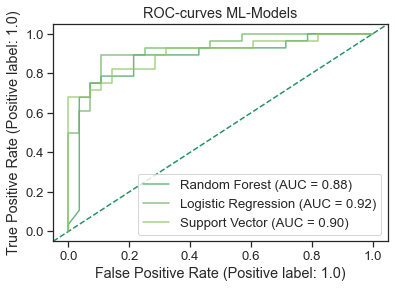

In [22]:
sns.set(style=("ticks"), font_scale=1.2)

sns.set_palette("summer", desat=1)
ax = plt.gca()
ax.plot([0, 1], [0, 1],linestyle='--', transform=ax.transAxes)
rf_disp = plot_roc_curve(rf, Test_features2, Test_labels2,name='Random Forest', ax=ax, alpha=0.8)
lr_disp = plot_roc_curve(lr, Test_features2, Test_labels2,name='Logistic Regression', ax=ax, alpha=0.8)
svc_disp = plot_roc_curve(svc, Test_features2, Test_labels2,name='Support Vector', ax=ax, alpha=0.8)
plt.title('ROC-curves ML-Models')
plt.savefig('Figures/ROC.png', dpi=300, bbox_inches='tight')
plt.show()

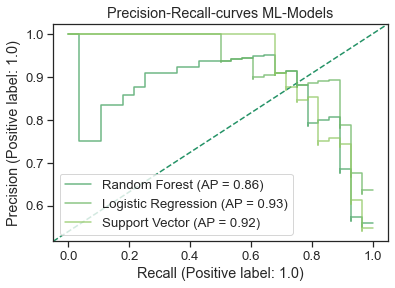

In [23]:
sns.set(style=("ticks"), font_scale=1.2)
sns.set_palette("summer")
ax = plt.gca()
ax.plot([0, 1], [0, 1],linestyle='--', transform=ax.transAxes)
rf_disp = plot_precision_recall_curve(rf, Test_features2, Test_labels2,name='Random Forest', ax=ax, alpha=0.8)
lr_disp = plot_precision_recall_curve(lr, Test_features2, Test_labels2,name='Logistic Regression', ax=ax, alpha=0.8)
svc_disp = plot_precision_recall_curve(svc, Test_features2, Test_labels2,name='Support Vector', ax=ax, alpha=0.8)
plt.title('Precision-Recall-curves ML-Models')
plt.savefig('Figures/PRC.png', dpi=300, bbox_inches='tight')
plt.show()

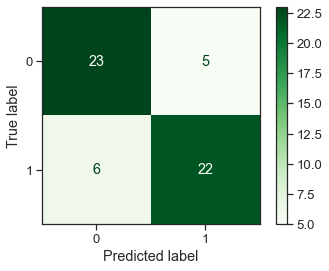

In [24]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(Test_labels2,rf_predictions2)
cm_display = ConfusionMatrixDisplay(cm).plot(cmap="Greens")
plt.savefig('Figures/ConfusionMatrix.png', dpi=300, bbox_inches='tight')

In [25]:
from sklearn.metrics import f1_score, matthews_corrcoef, fowlkes_mallows_score
print(f1_score(Test_labels2,rf_predictions2))
print(matthews_corrcoef(Test_labels2,rf_predictions2))
print(fowlkes_mallows_score(Test_labels2,rf_predictions2))


0.7999999999999999
0.6075304364080838
0.6728355732660294


## Stratified 10- fold cross validation: AUC

In [26]:
from sklearn.model_selection import train_test_split
SOLtarget = np.array(df_train['Binary_set'])
SOLdata = np.array(Train_features)

In [27]:
def get_score(model, x_train, x_test, y_train, y_test):
    model.fit(x_train, y_train)
    return model.score(x_test, y_test)

In [28]:
from sklearn.model_selection import StratifiedKFold
kf = StratifiedKFold(n_splits = 10)

In [29]:
AUC_svc = []
for train_index,test_index in kf.split(SOLdata, SOLtarget):
    x_train, x_test, y_train, y_test = SOLdata[train_index], SOLdata[test_index], \
                                        SOLtarget[train_index], SOLtarget[test_index]
    model = LogisticRegression(max_iter = 10000)
    AUC_svc.append(get_AUC(model, x_train, x_test, y_train, y_test))
print("Mean AUC score:")
print(np.mean(AUC_svc))

Mean AUC score:
0.9376482213438736


In [30]:
print(np.mean(cross_val_score(LogisticRegression(max_iter = 10000),SOLdata,SOLtarget,scoring= 'roc_auc',cv=10)))
print(np.mean(cross_val_score(SVC(),SOLdata,SOLtarget,scoring= 'roc_auc',cv=10)))
print(np.mean(cross_val_score(RandomForestClassifier(n_estimators = 100),SOLdata,SOLtarget,scoring= 'roc_auc',cv=10)))

0.9376482213438736
0.9409360402443406
0.9482617678763923


In [31]:
roc_rf = cross_val_score(RandomForestClassifier(n_estimators = 100),SOLdata,SOLtarget,scoring= 'roc_auc',cv=10)
f1_rf =cross_val_score(RandomForestClassifier(n_estimators = 100),SOLdata,SOLtarget,scoring= 'f1',cv=10)
acc_rf =cross_val_score(RandomForestClassifier(n_estimators = 100),SOLdata,SOLtarget,scoring= 'accuracy',cv=10)
bacc_rf =cross_val_score(RandomForestClassifier(n_estimators = 100),SOLdata,SOLtarget,scoring= 'balanced_accuracy',cv=10)
precision_rf =cross_val_score(RandomForestClassifier(n_estimators = 100),SOLdata,SOLtarget,scoring= 'precision',cv=10)
recall_rf =cross_val_score(RandomForestClassifier(n_estimators = 100),SOLdata,SOLtarget,scoring= 'recall',cv=10)

df_roc_rf = pd.DataFrame(roc_rf, columns=["score"])
df_f1_rf =pd.DataFrame(f1_rf, columns=["score"])
df_acc_rf =pd.DataFrame(acc_rf, columns=["score"])
df_bacc_rf =pd.DataFrame(bacc_rf, columns=["score"])
df_precision_rf =pd.DataFrame(precision_rf, columns=["score"])
df_recall_rf = pd.DataFrame(recall_rf, columns=["score"])

df_roc_rf['metric'] = 'AUC'
df_f1_rf['metric'] = 'F1'
df_acc_rf['metric'] = 'ACC'
df_bacc_rf['metric'] = 'BACC'
df_precision_rf['metric'] = 'Precision'
df_recall_rf['metric'] = 'Recall'

df_roc_rf['model'] = 'Aggregation'
df_f1_rf['model'] = 'Aggregation'
df_acc_rf['model'] = 'Aggregation'
df_bacc_rf['model'] = 'Aggregation'
df_precision_rf['model'] = 'Aggregation'
df_recall_rf['model'] = 'Aggregation'

df_scores = pd.concat([df_roc_rf, df_f1_rf, df_acc_rf,df_bacc_rf, df_precision_rf, df_recall_rf])
df_scores
df_scores.to_csv('AggregationScores.csv')


In [32]:
# LR = cross_val_score(LogisticRegression(max_iter = 10000),SOLdata,SOLtarget,scoring= 'roc_auc',cv=10)
# SVM = cross_val_score(SVC(),SOLdata,SOLtarget,scoring= 'roc_auc',cv=10)
# RF = cross_val_score(RandomForestClassifier(n_estimators = 100),SOLdata,SOLtarget,scoring= 'roc_auc',cv=10)

# mean_LR = np.mean(LR)
# mean_SVM = np.mean(SVM)
# mean_RF = np.mean(RF)

# std_LR = np.std(LR)
# std_SVM = np.std(SVM)
# std_RF = np.std(RF)

# labels = ['Logistic Regression', 'Support Vector Machine', 'Random Forest']
# x_pos = [1,2,3]

# means = [mean_LR, mean_SVM, mean_RF]
# stds = [std_LR, std_SVM, std_RF]

# fig, ax = plt.subplots()
# ax.bar(x_pos, means, yerr=stds, align='center', ecolor='black',alpha = 0.5, capsize=15, color="purple")
# ax.set_xticks(x_pos)
# ax.set_xticklabels(labels)
# ax.set_title("10-fold cross-validation")
# ax.yaxis.grid(True)
# plt.savefig('Figures/10FoldBarplot.png', dpi=300, bbox_inches='tight')

In [33]:
d = {'Model': ['Logistic Regression', 
                   'Support Vector', 'Random Forest'],
        'AUC':[0.9424995294560512, 0.9441558441558442, 0.9428900809335593]}
df_test = pd.DataFrame(data=d)

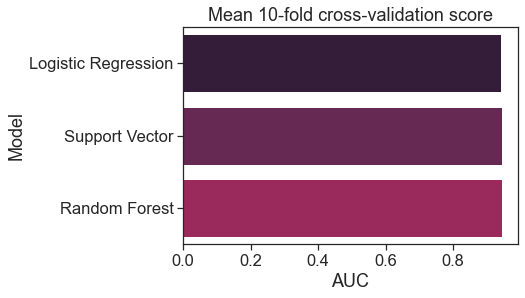

In [34]:
sns.set(style=("ticks"), font_scale=1.5)
sns.set_palette("rocket")
# fig = plt.figure(figsize=(10, 5))

ax = sns.barplot(x="AUC", y="Model", data=df_test, ).set_title('Mean 10-fold cross-validation score')
plt.savefig('Figures/10Fold.png', dpi=300, bbox_inches='tight')

## Features

In [35]:
features_continuous = ['length', 'hydr_count', 'polar_count', 'molecular_weight',
       'helix', 'turn', 'sheet', 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K',
       'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y', 'thsa_netsurfp2',
       'tasa_netsurfp2', 'rhsa_netsurfp2', 'disorder', 'A_exposed',
       'C_exposed', 'D_exposed', 'E_exposed', 'F_exposed', 'G_exposed',
       'H_exposed', 'I_exposed', 'K_exposed', 'L_exposed', 'M_exposed',
       'N_exposed', 'P_exposed', 'Q_exposed', 'R_exposed', 'S_exposed',
       'T_exposed', 'V_exposed', 'W_exposed', 'Y_exposed',
        'Aromaticity',
       'Instability_index', 'Gravy', 'isoelectric_point_x', 'charge_at_7',
       'charge_at_5', 'Polar_exposed', 'Hydrophobic_exposed','LHPpred']

features_categorical = ['PTM_MSD', 'Phosphorylation_MSD',
       'Glycosylation_MSD', 'Ubiquitination_MSD', 'SUMOylation_MSD',
       'Acetylation_MSD', 'Palmitoylation_MSD', 'Methylation_MSD']

agg = df_train[df_train["Binary_set"] == 1]
sol = df_train[df_train["Binary_set"] == 0]

## Mann-Whitney U test 

In [36]:
# create Series to save p-values
p_vals = pd.Series(index=features_continuous, dtype="float64", name='p_value')

# calculate p-values using Mann-Whitney U Test
for i, feature in enumerate(features_continuous):
    stat, p = mannwhitneyu(agg[feature], sol[feature]) # function returns statistic and p-value
    p_vals[i] = p 

# calculate adjusted p-value (FDR correction)
rejected, p_vals_adj = fdrcorrection(p_vals)
# create Series to save adjusted p-values
p_vals_adj = pd.Series(data=p_vals_adj, index=features_continuous, name='p_value_adjusted')

In [37]:
# save both p-values in dataframe
p_vals_comb = pd.concat([p_vals, p_vals_adj], axis=1)
# sort by adjusted p-value
p_vals_comb = p_vals_comb.sort_values(by='p_value_adjusted')

In [38]:
# print adjusted p-values (readable)
for i in range(len(p_vals_comb)):
    print(p_vals_comb.index[i], 'p=%.5f' % (p_vals_comb.p_value_adjusted[i]))

hydr_count p=0.00000
Gravy p=0.00000
disorder p=0.00000
Instability_index p=0.00000
tasa_netsurfp2 p=0.00000
turn p=0.00000
rhsa_netsurfp2 p=0.00000
polar_count p=0.00000
Aromaticity p=0.00000
V p=0.00000
LHPpred p=0.00000
E p=0.00000
molecular_weight p=0.00000
length p=0.00000
thsa_netsurfp2 p=0.00000
F p=0.00000
I p=0.00000
charge_at_5 p=0.00000
Q p=0.00000
Y p=0.00000
S_exposed p=0.00000
S p=0.00000
sheet p=0.00000
P p=0.00000
R p=0.00000
W p=0.00000
G p=0.00000
L p=0.00000
F_exposed p=0.00000
N_exposed p=0.00000
P_exposed p=0.00000
K p=0.00000
helix p=0.00000
T p=0.00007
C p=0.00023
A_exposed p=0.00083
Y_exposed p=0.00095
D_exposed p=0.01299
L_exposed p=0.01321
W_exposed p=0.01375
A p=0.01920
E_exposed p=0.04019
G_exposed p=0.04987
D p=0.07135
Hydrophobic_exposed p=0.07151
Q_exposed p=0.10080
I_exposed p=0.10828
N p=0.10961
M p=0.10961
Polar_exposed p=0.11564
V_exposed p=0.12067
K_exposed p=0.12067
R_exposed p=0.30415
T_exposed p=0.35416
isoelectric_point_x p=0.38514
H p=0.42922
C_

## Fishers Exact test

In [39]:
# create Series to save p-values
p_vals_cat = pd.Series(index=features_categorical, dtype="float64", name='p_value')

# calculate p-values using Fisher's exact test
for i, feature in enumerate(features_categorical):
    
    # get counts for each category
    A = sum(agg[feature]) 
    B = len(agg[feature]) - sum(agg[feature]) 
    C = sum(sol[feature])
    D = len(sol[feature]) - sum(sol[feature]) 
    
    # create 2x2 contingency table of counts
    table = np.array([[A, B],
                      [C, D]])
    
    odds, p = fisher_exact(table, alternative='two-sided') # function returns odds ratio and p-value
    p_vals_cat[i] = p 

# calculate adjusted p-value (FDR correction)
rejected, p_vals_adj_cat = fdrcorrection(p_vals_cat)
# create Series to save adjusted p-values
p_vals_adj_cat = pd.Series(data=p_vals_adj_cat, index=features_categorical, name='p_value_adjusted')


In [40]:
# save both p-values in dataframe
p_vals_comb_cat = pd.concat([p_vals_cat, p_vals_adj_cat], axis=1)
# sort by adjusted p-value
p_vals_comb_cat = p_vals_comb_cat.sort_values(by='p_value_adjusted')

In [41]:
# print adjusted p-values (readable)
for i in range(len(p_vals_comb_cat)):
    print(p_vals_comb_cat.index[i], 'p=%.5f' % (p_vals_comb_cat.p_value_adjusted[i]))


Phosphorylation_MSD p=0.00000
Methylation_MSD p=0.00000
SUMOylation_MSD p=0.00000
Glycosylation_MSD p=0.00001
Palmitoylation_MSD p=0.00005
Acetylation_MSD p=0.02852
Ubiquitination_MSD p=0.26081
PTM_MSD p=0.37218


In [42]:
sns.set(style=("ticks"), font_scale=4)
x1, x2= 0, 1
labels = ["Soluble"," Aggregator"]
dataset = new_df

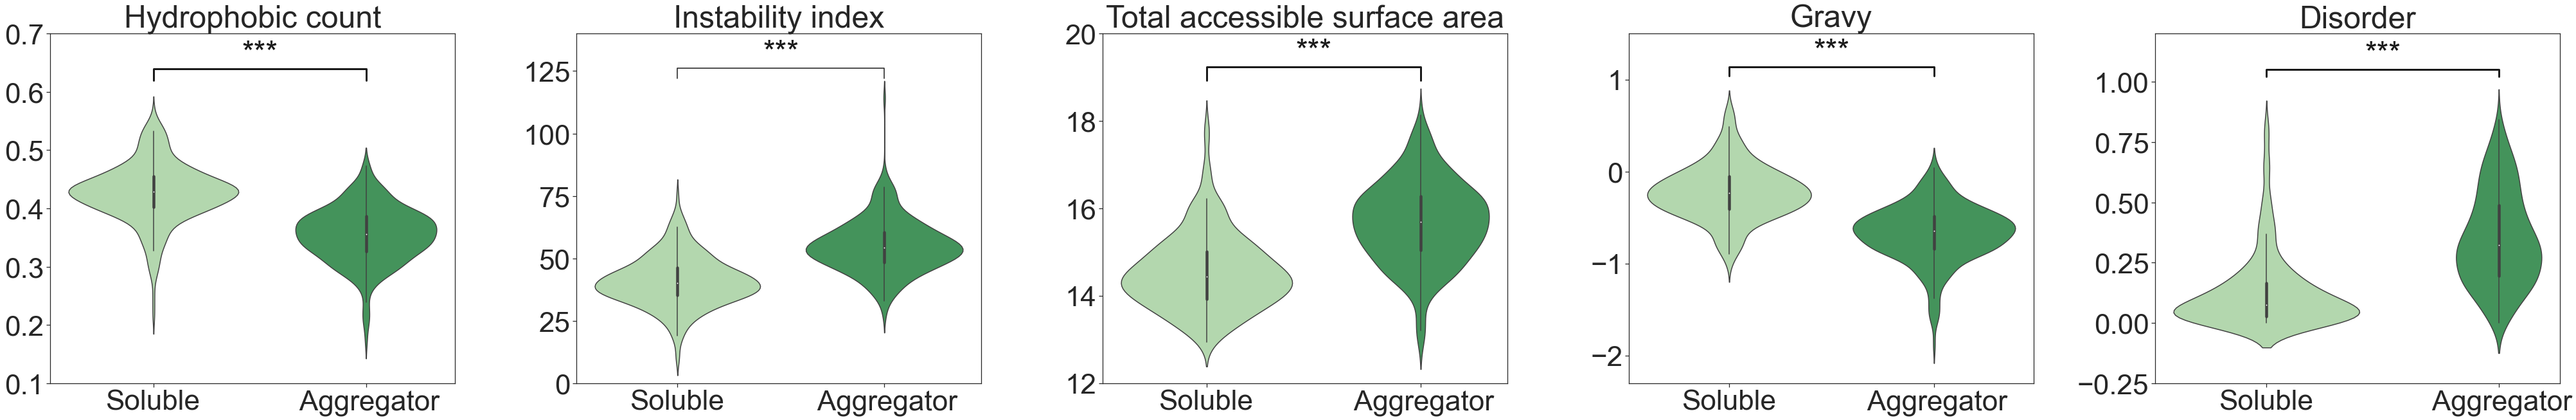

In [43]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, sharey=False, figsize=(70, 10))

sns.violinplot(x="Binary_set", y="hydr_count", data=dataset, ax=ax1, order=[1, 0], palette="Greens")
ax1.set(ylabel=None, xlabel=None, title="Hydrophobic count", xticklabels=(labels), ylim=(0.1,0.7) )
y, h, col = dataset["hydr_count"].max() + 0.06, 0.02, 'k'
ax1.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=3, c=col)
ax1.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col)


sns.violinplot(x="Binary_set", y="Instability_index", data=dataset, ax=ax2, order=[1, 0], palette="Greens")
ax2.set(ylabel=None, xlabel=None, title="Instability index", xticklabels=(labels),ylim=(0,140))
y, h, col = dataset["Instability_index"].max() + 8, 4, 'k'
ax2.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
ax2.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col)

sns.violinplot(x="Binary_set", y="tasa_netsurfp2", data=dataset, ax=ax3, order=[1, 0], palette="Greens")
ax3.set(ylabel=None, xlabel=None, title="Total accessible surface area", xticklabels=(labels),ylim=(12,20))
y, h, col = dataset["tasa_netsurfp2"].max() + 0.8, 0.3, 'k'
ax3.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=3, c=col)
ax3.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col)

sns.violinplot(x="Binary_set", y="Gravy", data=dataset, ax=ax4, order=[1, 0], palette="Greens")
ax4.set(ylabel=None, xlabel=None, title="Gravy", xticklabels=(labels),ylim=(-2.3,1.5))
y, h, col = dataset["Gravy"].max() + 0.35, 0.1, 'k'
ax4.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=3, c=col)
ax4.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col)

sns.violinplot(x="Binary_set", y="disorder", data=dataset, ax=ax5, order=[1, 0], palette="Greens")
ax5.set(ylabel=None, xlabel=None, title="Disorder", xticklabels=(labels),ylim=(-0.25,1.2))
y, h, col = dataset["disorder"].max() + 0.18,0.030, 'k'
ax5.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=3, c=col)
ax5.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col)


plt.savefig('Figures/ViolinPlots.png', dpi=300, bbox_inches='tight')
plt.subplots_adjust(wspace = 0.3)
plt.show()


## Feature correlation

In [44]:
# calculate pairwise correlation
corr_all = new_df.corr()

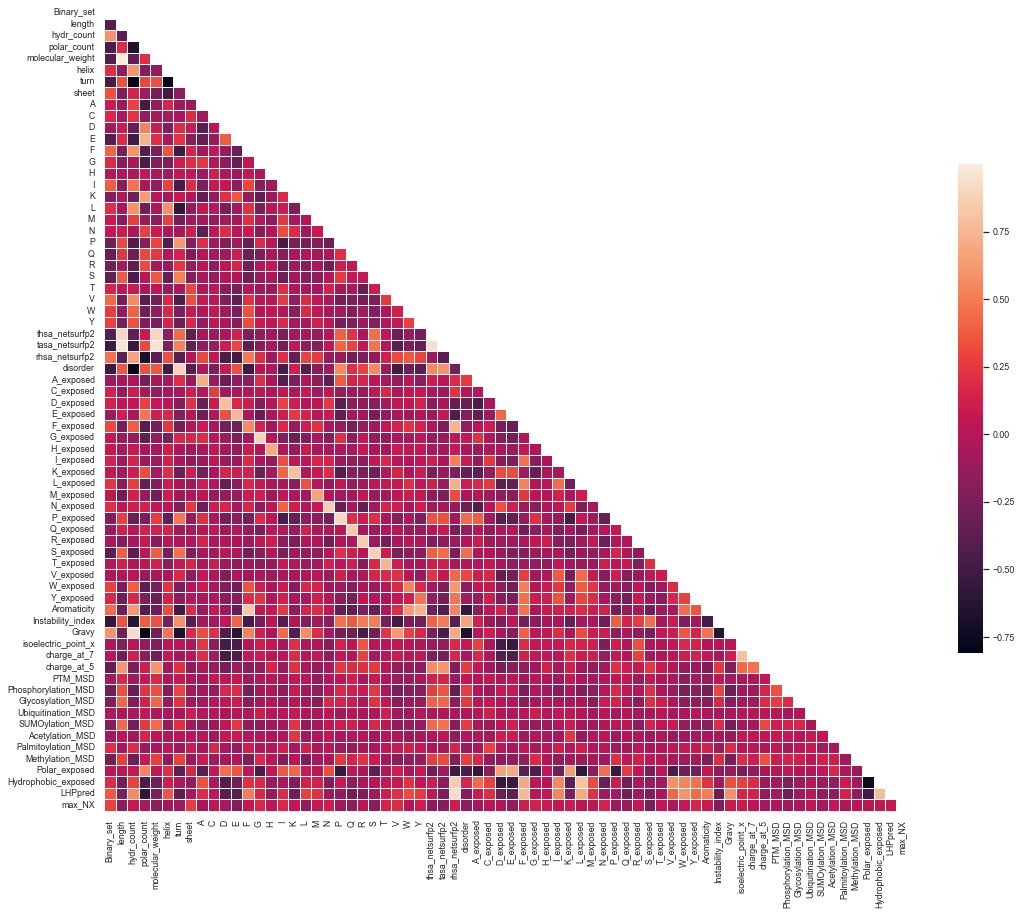

In [45]:
sns.set(font_scale=0.8)
mask = np.triu(np.ones_like(corr_all, dtype=bool))
sns.set_style(style = 'white')
sns.set_palette("rocket")
fig, ax = plt.subplots(figsize=(18, 18))
cmap = sns.diverging_palette(10, 250, as_cmap=True)
sns.heatmap(corr_all, mask=mask, cmap="rocket", square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=ax,
            xticklabels=True, yticklabels=True)
plt.savefig('Figures/Correlations.png', dpi=300, bbox_inches='tight')


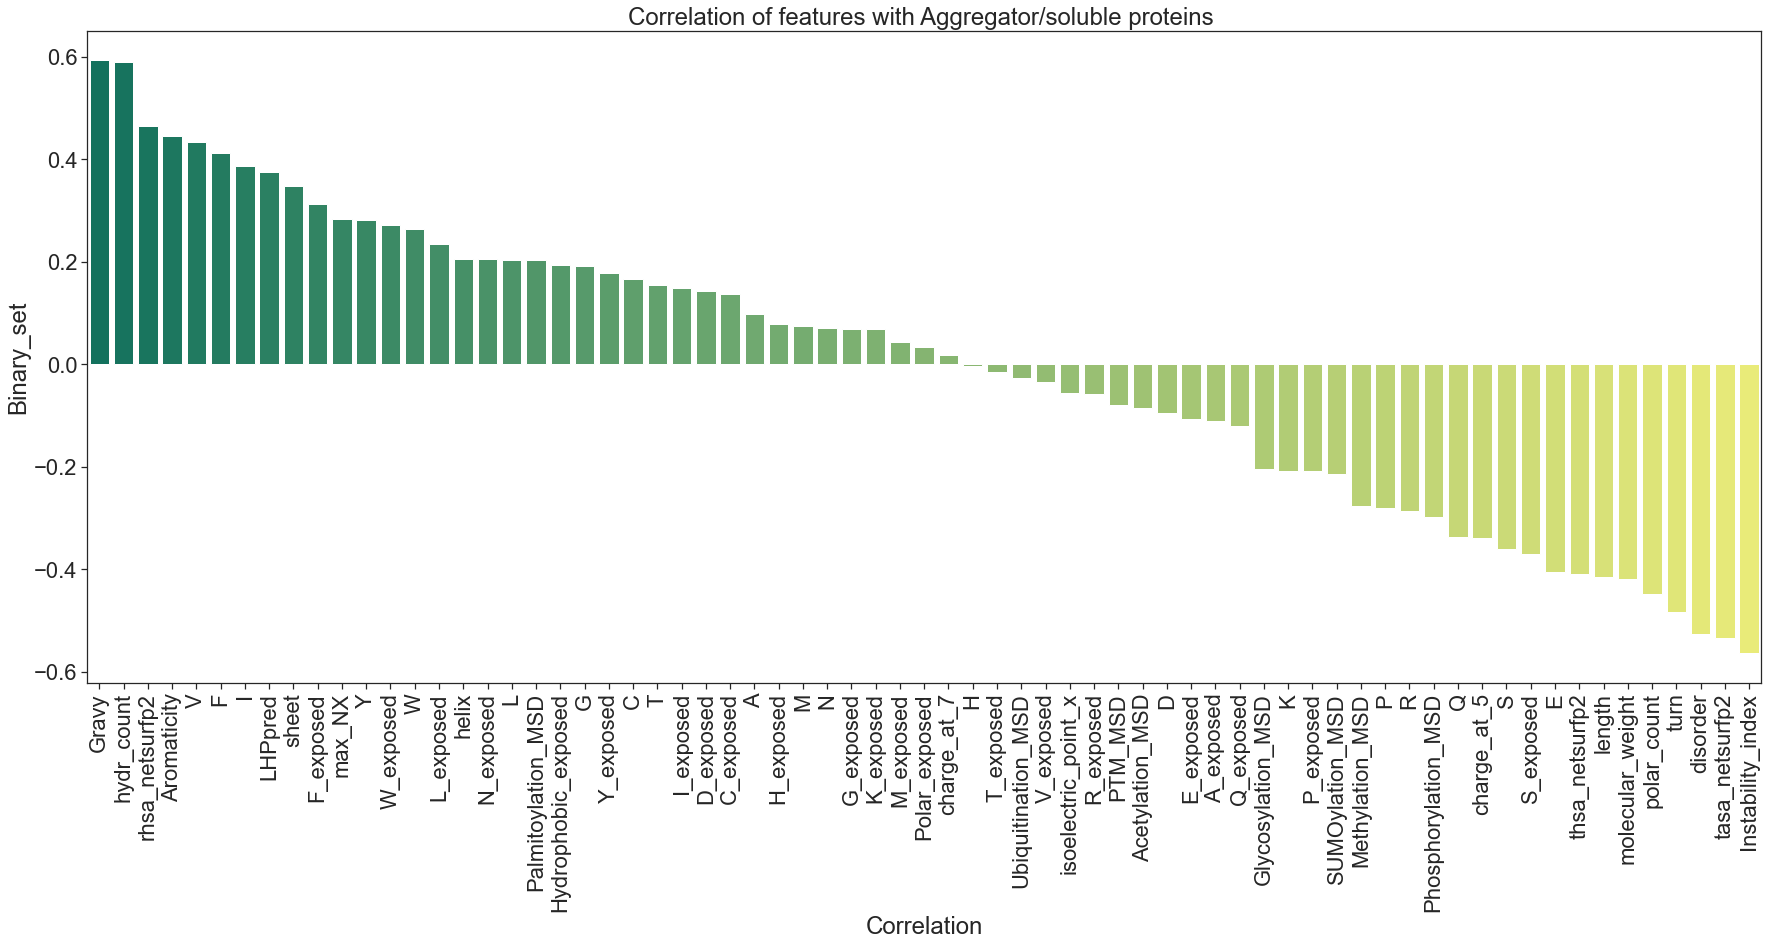

In [46]:
sns.set(style=("ticks"), font_scale=2)

correlations_all = corr_all[["Binary_set"]].sort_values(by="Binary_set", ascending=False)[1:]
correlations_all.reset_index(inplace=True)

colors_all = ["b" if (x > 0) else "r" for x in correlations_all["Binary_set"]]

fig = plt.figure(figsize=(30, 12)) 
sns.barplot(x="index", y="Binary_set", data=correlations_all, palette="summer")
plt.xlabel("Features") 
plt.xticks(rotation=90)
plt.xlabel("Correlation")
plt.title("Correlation of features with Aggregator/soluble proteins ")
plt.savefig('Figures/featureCorrelation.png', dpi=300, bbox_inches='tight')